# Boilerplate Setup Code

This includes import statements and setting up google drive access to fetch the data

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import ast
from matplotlib.pyplot import figure
from google.colab import drive
from collections import defaultdict

In [ ]:
drive.mount('/content/drive')

DIRECTORY = '/content/drive/Shareddrives/CMPE295' 

if os.getcwd() != DIRECTORY:
  os.chdir(DIRECTORY)

In [ ]:
recipes_df = pd.read_csv('./Food_Com_Dataset/RAW_recipes.csv')

# Exploratory Data Analysis

Let's take a look at what we have in our dataframe

In [ ]:
recipes_df.sample(5).iloc[0].tags

"['30-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'preparation', 'lunch', 'poultry', 'dietary', 'sandwiches', 'meat']"

We'll expand the nutrition column with individual headers for the different nutrition values

In [ ]:
headers = ['cal', 'totalFat', 'sugar', 'sodium', 'protein', 'satFat', 'carbs']
nutrition = recipes_df['nutrition'].str.replace('[','').str.replace(']','').str.split(',').to_list()
nutrition_df = pd.DataFrame(nutrition, index=recipes_df.index, columns=headers)
recipes_df = recipes_df.join(nutrition_df).drop(columns=['nutrition'])

In [ ]:
recipes_df.head()

,name,id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,n_ingredients,cal,totalFat,sugar,sodium,protein,satFat,carbs
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,51.5,0.0,13.0,0.0,2.0,0.0,4.0
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,173.4,18.0,0.0,17.0,22.0,35.0,1.0
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13,269.8,22.0,32.0,48.0,39.0,27.0,5.0
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11,368.1,17.0,10.0,2.0,14.0,8.0,20.0
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8,352.9,1.0,337.0,23.0,3.0,0.0,28.0


## Outlier Analysis

In [ ]:
recipes_df.describe()

,id,minutes,contributor_id,n_steps,n_ingredients
count,231637.000000,2.316370e+05,2.316370e+05,231637.000000,231637.000000
mean,222014.708984,9.398546e+03,5.534885e+06,9.765499,9.051153
std,141206.635626,4.461963e+06,9.979141e+07,5.995128,3.734796
min,38.000000,0.000000e+00,2.700000e+01,0.000000,1.000000
25%,99944.000000,2.000000e+01,5.690500e+04,6.000000,6.000000
50%,207249.000000,4.000000e+01,1.736140e+05,9.000000,9.000000
75%,333816.000000,6.500000e+01,3.982750e+05,12.000000,11.000000
max,537716.000000,2.147484e+09,2.002290e+09,145.000000,43.000000


Here's a high level overview of the discrete numerical data in our dataframe. Based on this we can tell that we have outliers, some of them are possibly anomalies that we'll have to delete for instance the max minutes value looks like an anomaly, so does a recipe with 0 minutes prep time or even 0 steps involved.

### `minutes`

In [ ]:
minutes_outliers_df = recipes_df[recipes_df['minutes'] <= 0*60].sort_values(by='minutes')
minutes_outliers_df.describe() 

,id,minutes,contributor_id,n_steps,n_ingredients
count,1094.000000,1094.0,1094.000000,1094.000000,1094.000000
mean,7781.452468,0.0,24377.671846,10.166362,8.915905
std,13615.216407,0.0,43693.918288,6.359878,3.577947
min,387.000000,0.0,1530.000000,1.000000,2.000000
25%,3259.250000,0.0,1534.000000,6.000000,6.000000
50%,4541.000000,0.0,1756.000000,9.000000,8.000000
75%,7120.500000,0.0,39547.000000,13.000000,11.000000
max,282837.000000,0.0,580209.000000,54.000000,24.000000


In [ ]:
minutes_outliers_df.sample(1).iloc[0].steps

"['drain & rinse corn & beans , add cilantro , green pepper onion , tomatoes & jalapeno', 'blend well', 'drizzle the oil and lime juice over top , then add spices', 'stir', 'refrigerate 2-4 hours or overnight', 'serve with tortilla chips']"

We'll set 15 minutes as the minimum time for all our recipes

In [ ]:
recipes_df.loc[recipes_df['minutes'] < 15, 'minutes'] = 15

In [ ]:
minutes_outliers_df = recipes_df[recipes_df['minutes'] > 24*90*60].sort_values(by='minutes')
minutes_outliers_df.describe() 

,id,minutes,contributor_id,n_steps,n_ingredients
count,20.000000,2.000000e+01,20.000000,20.000000,20.000000
mean,198681.050000,1.075830e+08,228997.050000,10.400000,4.600000
std,119749.394419,4.801428e+08,195599.786236,6.336195,2.087557
min,2714.000000,1.296100e+05,1549.000000,4.000000,2.000000
25%,139953.500000,1.296275e+05,32653.750000,7.000000,3.000000
50%,226244.500000,1.699200e+05,231335.500000,8.500000,4.000000
75%,240954.250000,2.268125e+05,328177.250000,11.250000,6.250000
max,447963.000000,2.147484e+09,576273.000000,31.000000,8.000000


In [ ]:
minutes_outliers_df.sample(1).iloc[0].steps

"['in a quart jar , add strawberries , 1 cup sugar , and vodka', 'seal jar tightly , and place in a dry , dark place for about 2 weeks', 'after two weeks , strain the liquid using a double layer of cheese cloth', 'gently squeeze the berries , getting as much juice from the berries as possible', 'in a fresh quart jar , add the second cup of sugar , glycerin , water to top and the strained liquid', 'seal and store again in a dark place until sugar is dissolved', 'once the sugar has all dissolved , bottle the resulting liqueur in a fresh bottle and let age for roughly 3 months']"

It seems that it would be unreasonable to place a maximum cap on the recipe prep time since there are recipes that actually take this long especially those involving brewing of alcohol.

### `n_steps`

In [ ]:
n_steps_outliers_df = recipes_df[recipes_df['n_steps'] < 1].sort_values(by='n_steps')
n_steps_outliers_df.describe() 

,id,minutes,contributor_id,n_steps,n_ingredients
count,1.0,1.0,1.0,1.0,1.0
mean,176767.0,90.0,331268.0,0.0,12.0
std,NaN,NaN,NaN,NaN,NaN
min,176767.0,90.0,331268.0,0.0,12.0
25%,176767.0,90.0,331268.0,0.0,12.0
50%,176767.0,90.0,331268.0,0.0,12.0
75%,176767.0,90.0,331268.0,0.0,12.0
max,176767.0,90.0,331268.0,0.0,12.0


In [ ]:
n_steps_outliers_df.sample(1)

,name,id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,n_ingredients,cal,totalFat,sugar,sodium,protein,satFat,carbs
3381,all season bread,176767,90,331268,2006-07-10,"['time-to-make', 'course', 'main-ingredient', ...",0,[],just change the fruit/vegetable in this recipe...,"['flour', 'baking soda', 'salt', 'baking powde...",12,198.8,11.0,70.0,18.0,5.0,5.0,10.0


In [ ]:
recipes_df = recipes_df.loc[recipes_df['n_steps'] > 0]

## `n_steps` box plot

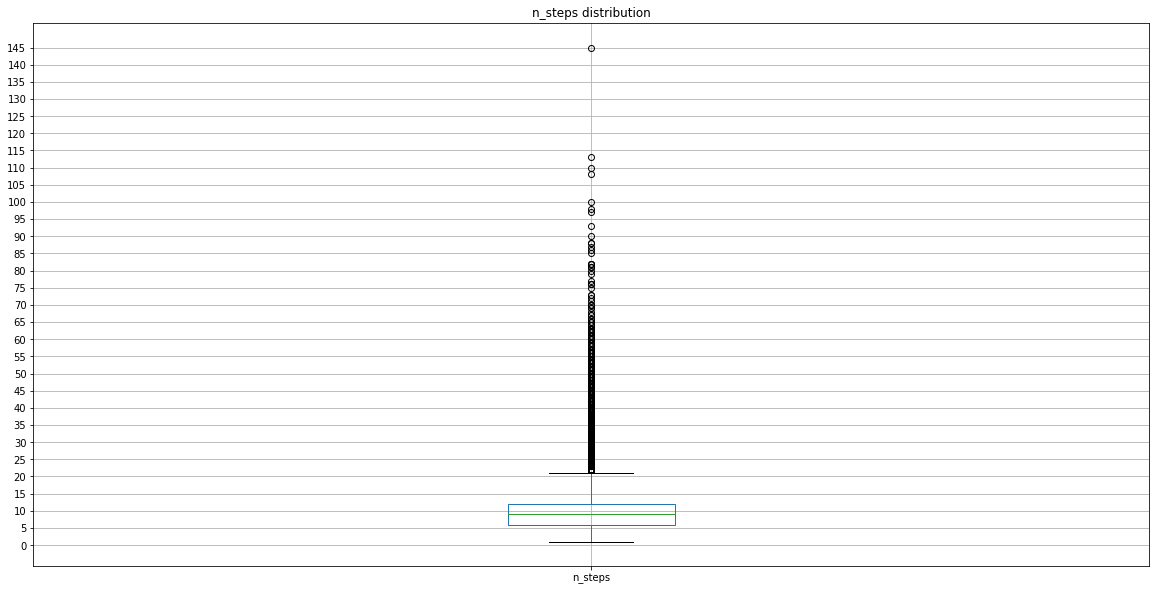

In [ ]:
figure(figsize=(20, 10))
y = list(range(0, 150, 5))
recipes_df['n_steps'].plot(
    kind='box', 
    title= 'n_steps distribution', 
    grid=True, 
    yticks= y)

##`n_ingredients` box plot

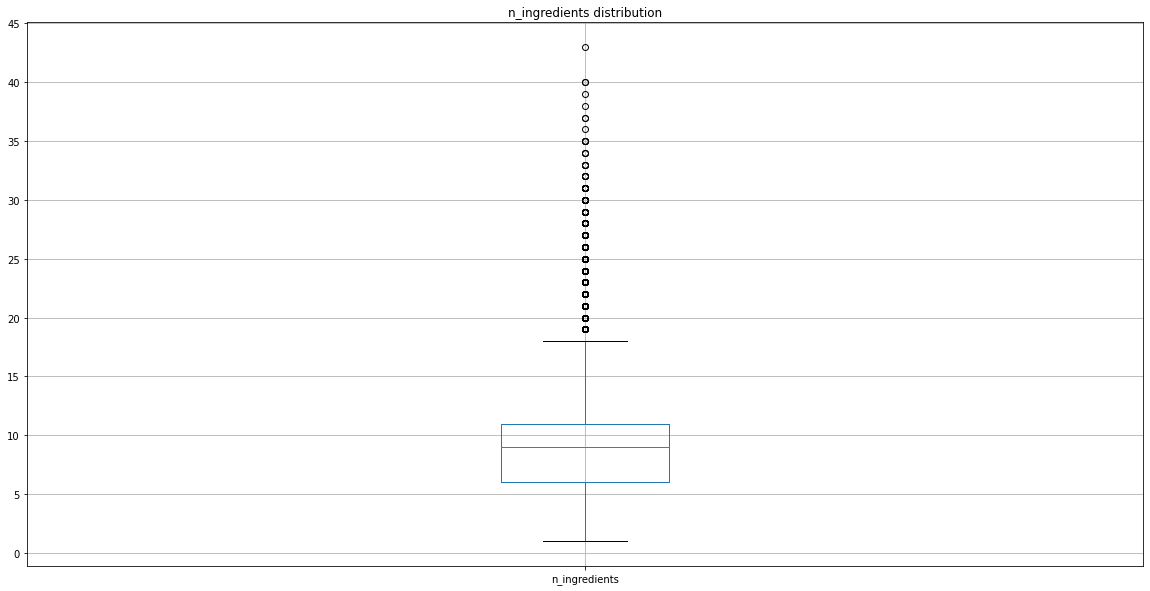

In [ ]:
figure(figsize=(20, 10))
y = list(range(0, 50, 5))
recipes_df['n_ingredients'].plot(
    kind='box', 
    title= 'n_ingredients distribution', 
    grid=True, 
    yticks=y)

## `minutes` boxplot

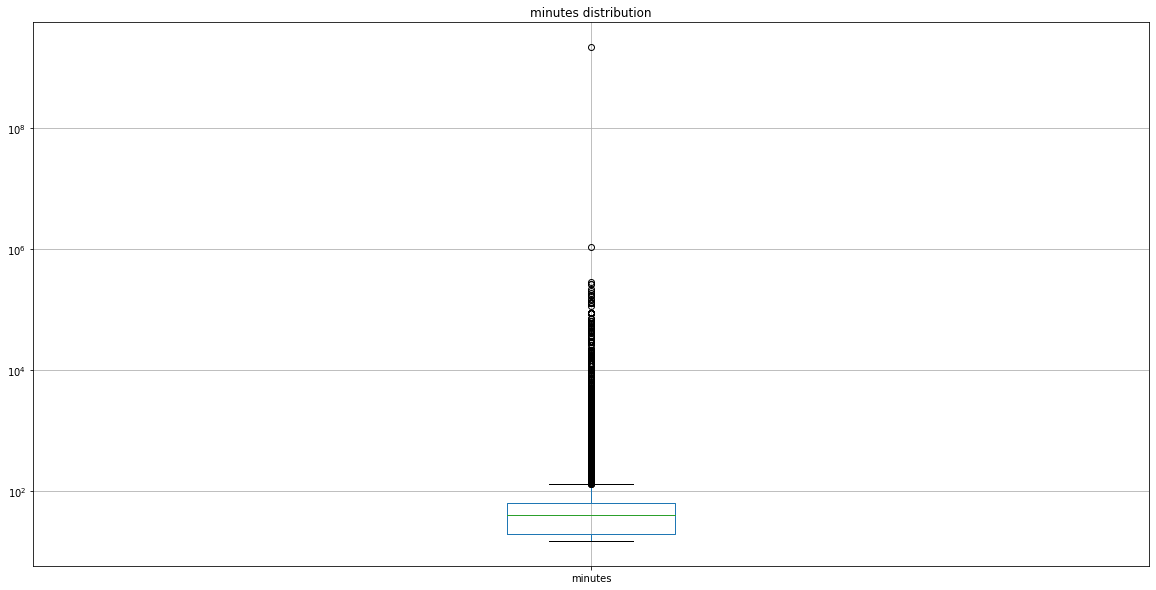

In [ ]:
figure(figsize=(20, 10))
recipes_df['minutes'].plot(
    kind='box', 
    title='minutes distribution', 
    grid=True, 
    logy=True)

## `tags` boxplot

The tags provide additional information about a recipe and will come in handy when building an enbedding because of the information that they contain. It's therefore important that these tags are not only useful but that they convey information about the recipe.

In [ ]:
# tags are stored as string values, we'll convert them to a list of lists
tags_str = recipes_df['tags'].tolist()
tags = [ast.literal_eval(t) for t in tags_str]

In [ ]:
def get_tag_counts(tags):
  # helper method that takes in a list of lists of tags and returns
  # a dictionary with the tags as the keys and the values as the counts
  tags_flattened = [t for lst in tags for t in lst]
  tags_dict = dict.fromkeys(set(tags_flattened), 0)
  
  for t in tags_flattened:
    tags_dict[t] += 1

  return tags_dict

In [ ]:
tags_dict = get_tag_counts(tags)

Let's explore the distribution of the count of the tags 

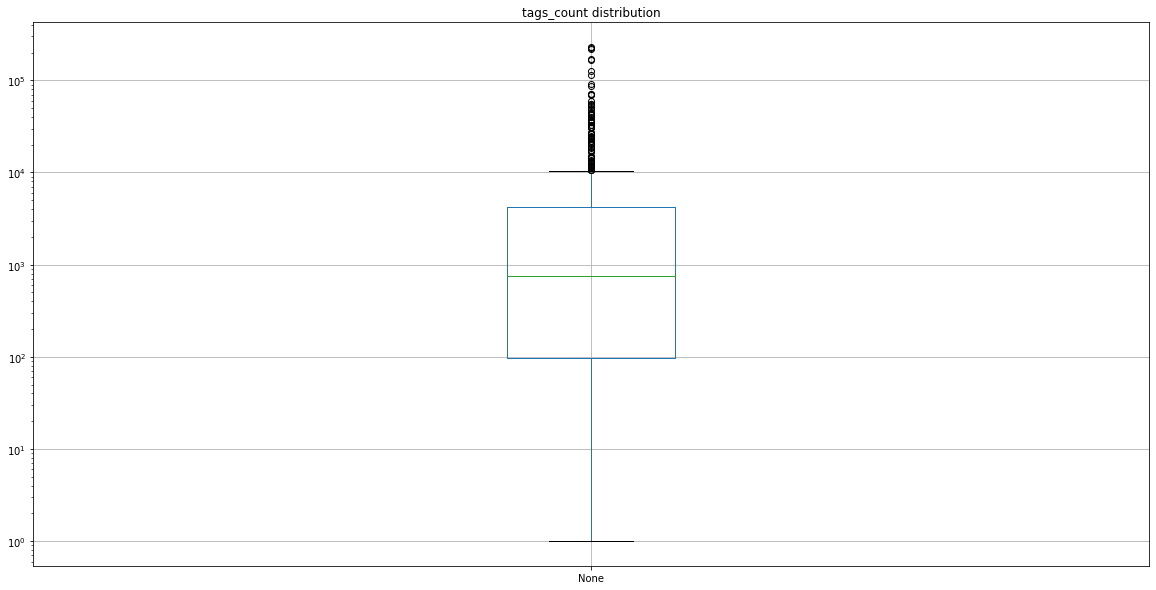

In [ ]:
figure(figsize=(20, 10))
pd.Series(tags_dict.values()).plot(
    kind='box',
    title='tags_count distribution',
    grid=True,
    logy=True
)

Upon inspection some of the tags used either did not make sense or did not convey a clear meaning. These were manually identified so we can remove them later.

In [ ]:
tags_series = pd.Series(tags_dict).sort_values(ascending=False)

In [ ]:
tags_series.head(30)

preparation           230545
time-to-make          225325
course                218147
main-ingredient       170445
dietary               165091
easy                  126061
occasion              114144
cuisine                91164
low-in-something       85776
main-dish              71786
equipment              70436
60-minutes-or-less     69990
number-of-servings     58948
meat                   56042
30-minutes-or-less     55077
vegetables             53813
taste-mood             52142
4-hours-or-less        49496
north-american         48478
3-steps-or-less        44932
15-minutes-or-less     43934
low-sodium             43349
desserts               43203
low-carb               42189
healthy                40340
dinner-party           37561
low-cholesterol        36743
low-calorie            36429
vegetarian             35651
beginner-cook          35561
dtype: int64

In [ ]:
tags_series.tail(50)

breakfast-eggs                                                           2
side-dishes-beans                                                        2
beans-side-dishes                                                        2
heirloom-historical-recipes                                              2
pasta-salad                                                              2
spaghetti-sauce                                                          2
pork-loin                                                                1
baked-beans                                                              1
pot-roast                                                                1
chicken-stew                                                             1
breakfast-potatoes                                                       1
eggs-breakfast                                                           1
cranberry-sauce                                                          1
for-large-groups-holiday-

In [ ]:
TAGS_TO_REMOVE = {
  'less_thansql:name_topics_of_recipegreater_than',
  'Throw the ultimate fiesta with this sopaipillas recipe from Food.com.',
  'presentation',
  '',
  'time-to-make',
  'course',
  'preparation',
  'number-of-servings',
  'equipment',
  'taste-mood',
  'main-ingredient',
  'occasion',
  'dietary',
  'copycat',
  'water-bath',
  'cuisine',
  'weeknight',
  'novelty',
  'technique',
  'holiday-event',
  'holiday',
  'flat-shapes',
  'free-of-something',
  'high-in-something',
  'low-in-something',
  'ragu-recipe-contest',
  'refrigerator',
  'freezer',
  'reynolds-wrap',
  'small-appliance',
  'pasta-rice-and-grains',
  'celebrity',
  'gifts',
  'stocks',
  'novelty',
  'birthday',
  'independence-day',
  'no-shell-fish',
  'heirloom-historical',
  'heirloom-historical-recipes',
  'brown-bag',
  'egg-free',
  'unprocessed-freezer',
  'nut-free',
  }

In [ ]:
def remove_tag(tags):
  tags = set(ast.literal_eval(tags))
  for t in TAGS_TO_REMOVE:
    if t in tags:
      tags.remove(t)
  return list(tags)

In [ ]:
cleaned_tags = recipes_df['tags'].apply(remove_tag)
cleaned_recipes_df = recipes_df.copy()
cleaned_recipes_df['tags'] = cleaned_tags

In [ ]:
cleaned_tags

0         [side-dishes, vegetarian, squash, vegetables, ...
1         [north-american, pizza, meat, pork, oven, main...
2         [main-dish, chili, crock-pot-slow-cooker, 4-ho...
3         [side-dishes, potatoes, vegetables, christmas,...
4         [vegetarian, vegetables, north-american, 4-hou...
                                ...                        
231632    [vegetables, north-american, 3-steps-or-less, ...
231633    [vegetarian, condiments-etc, herb-and-spice-mi...
231634    [eggs, finger-food, served-cold, eggs-dairy, 3...
231635    [desserts, for-large-groups, high-calcium, han...
231636    [desserts, for-large-groups, rolled-cookies, k...
Name: tags, Length: 231636, dtype: object

Now that we've cleaned the tags, let's explore the distribution once more and see if there are any significant changes

In [ ]:
cleaned_tags_dict = get_tag_counts(cleaned_tags.tolist())

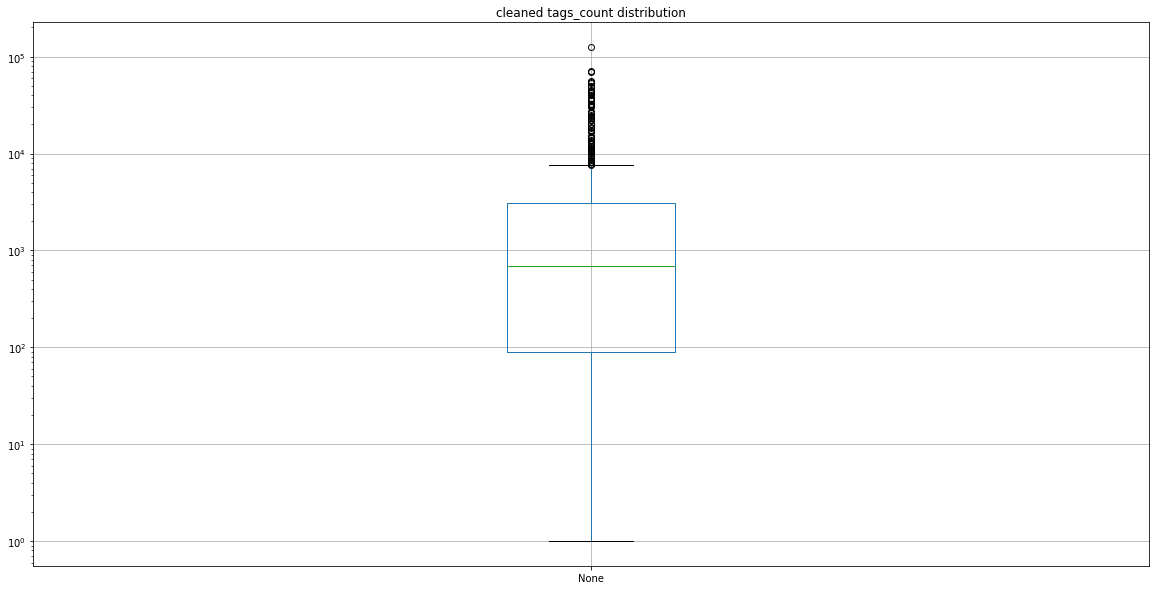

In [ ]:
figure(figsize=(20, 10))
pd.Series(cleaned_tags_dict.values()).plot(
    kind='box',
    title='cleaned tags_count distribution',
    grid=True,
    logy=True
)

Not much significant change observed overall

Let's also look at the distiribution of the number of tags per recipe

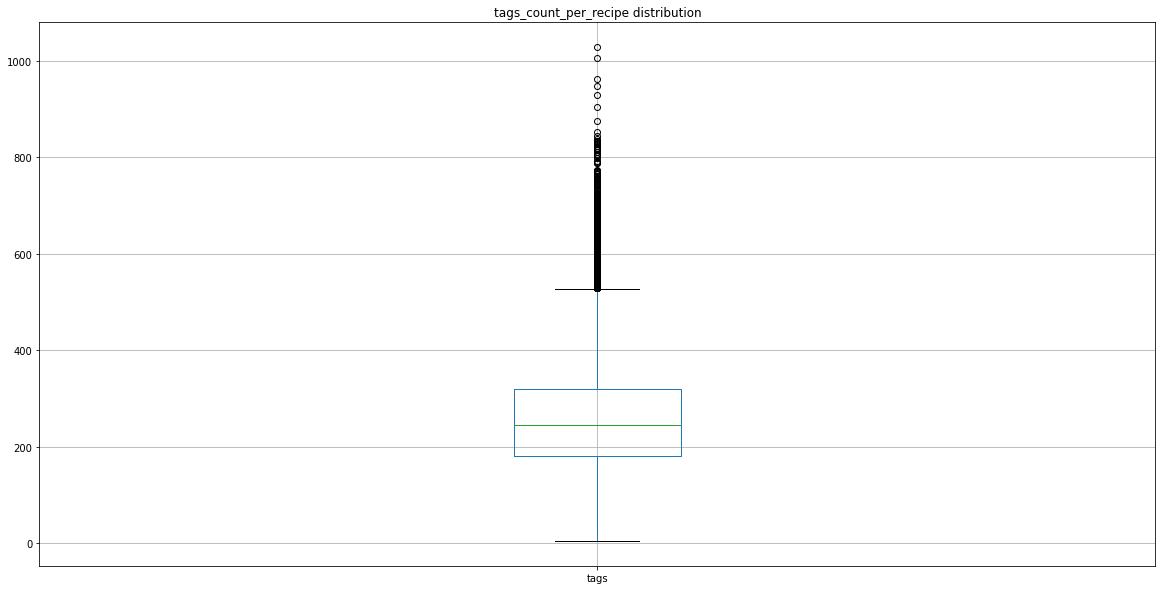

In [ ]:
figure(figsize=(20, 10))
tags_count = recipes_df['tags'].apply(lambda l: len(l))
tags_count.plot(
    kind='box',
    title='tags_count_per_recipe distribution',
    grid=True,
)

In [ ]:
MAPPING = {
  'healthy-2': ['healthy'],
  'crusts-pastry-dough-2': ['pastry-dough'],
  'crock-pot-main-dish':  ['crock-pot', 'main-dish'],
  'crock-pot-slow-cooker': ['crock-pot', 'slow-cooker'],
  'cookies-and-brownies': ['cookies', 'brownies'],
  'condiments-etc': ['condiments'],
  'cobblers-and-crips': ['cobblers', 'crisps'],
  'clear-soups': ['clear-soup', 'soup'],
  'chocolate-chip-cookies': ['chocolate-chip-cookies', 'cookies'],
  'cookies-and-brownies': ['cookies', 'brownies'],
  'drop-cookies': ['drop-cookies', 'cookies'],
  'savory-sauces': ['savory', 'sauce'],
  'baked-beans': ['baked-beans', 'beans'],
  'chicken-stews': ['chicken', 'stew'],
  'chicken-stew': ['chicken', 'stew'],
  'chicken-crockpot': ['chicken', 'crock-pot'],
  'cabbage': ['cabbage', 'vegetables'],
  'breakfast-potatoes': ['breakfast', 'potatoes'],
  'breakfast-eggs': ['breakfast', 'eggs'],
  'breakfast-casseroles': ['breakfast', 'casserole'],
  'casseroles': ['casserole'],
  'breads': ['bread'],
  'bread-pudding': ['bread', 'pudding'],
  'bread-machine': ['bread'],
  'bok-choys': ['bok-choy'],
  'black-bean-soup': ['black-beans', 'soup', 'beans'],
  'bisques-cream-soups': ['bisque', 'soup', 'cream-soup'],
  'beverages': ['beverage'],
  'beginner-cook': ['beginner'],
  'beef-sauces': ['beef', 'sauce'],
  'beef-organ-meats': ['beef'],
  'beef-crock-pot': ['crock-pot', 'beef'],
  'beef-barley-soup': ['beef', 'barley', 'soup'],
  'beans-side-dishes': ['beans', 'side-dish'],
  'side-dishes': ['side-dish'],
  'bean-soup': ['beans', 'soup'],
  'baked-beans': ['beans', 'baked-beans'],
  'appetizers': ['appetizer'],
  'desserts-fruit': ['dessert', 'fruit'],
  'desserts': ['dessert'],
  'dessert-easy': ['dessert', 'easy'],
  'dehydrator': ['dehydrated'],
  'high-in-something-diabetic-friendly': ['diabetic'],
  'condiments-etc': ['condiments'],
  'desserts-fruit': ['desserts', 'fruit'],
  'desserts-easy': ['desserts', 'easy'],
  'dips-lunch-snacks': ['dips', 'lunch', 'snacks'],
  'dips-summer': ['dips', 'summer'],
  'duck-breasts': ['duck'],
  'eggs-breakfast': ['eggs', 'breakfast'],
  'eggs-dairy': ['eggs', 'dairy'],
  'fillings-and-frostings-chocolate': ['chocolate'],
  'for-large-groups-holiday-event': ['for-large-groups'],
  'goose': ['poultry'],
  'granola-and-porridge': ['granola', 'porridge'],
  'halloween-cakes': ['halloween', 'cakes'],
  'halloween-cocktails': ['halloween', 'cocktails'],
  'halloween-cupcakes': ['halloween', 'cupcakes'],
  'ham-and-bean-soup': ['ham', 'beans', 'soup'],
  'drop-cookies': ['cookies', 'drop-cookies'],
  'hand-formed-cookies': ['cookies', 'hand-formed-cookies'],
  'heirloom-historical-recipes': ['heirloom-historical'],
  'irish-st-patricks-day': ['irish', 'st-patricks-day'],
  'jewish-ashkenazi': ['jewish'],
  'jewish-sephardi': ['jewish'],
  'passover': ['jewish', 'passover'],
  'kosher': ['jewish', 'kosher'],
  'lamb-sheep-main-dish': ['lamb', 'main-dish'],
  'lasagne': ['lasagna'],
  'main-dish-beef': ['main-dish', 'beef'],
  'main-dish-chicken': ['main-dish', 'chicken'],
  'main-dish-pasta': ['main-dish', 'pasta'],
  'main-dish-pork': ['main-dish', 'pork'],
  'main-dish-seafood': ['main-dish', 'seafood'],
  'mashed-potatoes': ['mashed-potatoes', 'potatoes'],
  'middle-eastern-main-dish': ['middle-eastern', 'main-dish'],
  'mushroom-soup': ['mushrooms', 'soup'],
  'pasta-elbow-macaroni': ['pasta', 'elbow-macaroni'],
  'pasta-rice-and-grains-elbow-macaroni': ['pasta', 'elbow-macaroni'],
  'pasta-salad': ['pasta', 'salad'],
  'pork-crock-pot': ['pork', 'crock-pot'],
  'pies-and-tarts': ['pies', 'tarts'],
  'pancakes-and-waffles': ['pancakes', 'waffles'],
  'quick-breads': ['quick-bread', 'bread'],
  'pork-loins': ['pork-loin'],
  'pork-loins-roast': ['pork-loin', 'roast'],
  'prepared-potatoes': ['potatoes'],
  'pumpkin-bread': ['pumpkin', 'bread'],
  'quick-breads': ['bread'],
  'food-processor-blender': ['food-processor', 'blender'],
  'roast-beef-comfort-food': ['roast-beef', 'comfort-food', 'roast'],
  'roast-beef-main-dish': ['roast-beef', 'main-dish', 'roast'],
  'rolled-cookies': ['rolled-cookies', 'cookies'],
  'rosh-hashanah': ['rosh-hashana'],
  'served-hot-new-years': ['served-hot', 'new-years'],
  'shrimp-main-dish': ['shrimp', 'main-dish'],
  'side-dishes-beans': ['side-dishes', 'beans'],
  'simply-potatoes': ['potatoes'],
  'simply-potatoes2': ['potatoes'],
  'snacks-kid-friendly': ['snacks', 'kid-friendly'],
  'snacks-sweet': ['snacks'],
  'soups-stews': ['soups', 'stews'],
  'spahgetti-sauce': ['spaghetti', 'sauce'],
  'steaks': ['steak'],
  'stews-poultry': ['stews', 'poultry'],
  'stuffings-dressing': ['stuffings', 'dressing'],
  'sugar-cookies': ['cookies'],
  'superbowl': ['super-bowl'],
  'turkey-breasts': ['turkey'],
  'turkey-burgers': ['turkey', 'burgers'],
  'veggie-burgers': ['vegetables', 'burgers'],
  'very-low-carbs': ['keto'],
  'yams-sweet-potatoes': ['yams', 'sweet-potatoes'],
  'salad-dressings': ['salad-dressing'],
  'rolls-biscuits': ['rolls', 'biscuits'],
  'puddings-and-mousses': ['puddings', 'mousses'],
  'pitted-fruit': ['pitted-fruit', 'fruit'],
  'orange-roughy': ['fish', 'orange-roughy'],
  'omelets-and frittata': ['omelets', 'frittatas'],
  'oamc-freezer-make-ahead': ['oamc'],
  'kiwifruit': ['kiwi', 'fruit'],
  'ontario': ['canadian'],
  'quebec': ['canadian'],
  'iranian-persian': ['iranian', 'persian'],
  'herb-and-spice-mixes': ['herbs-and-spice-mix'],
  'inexpensive': ['cheap'],
  'pork-ribs': ['pork-ribs', 'ribs', 'pork'],
  'beef-ribs': ['beef-ribs', 'beef', 'ribs'],
  'soy-tofu': ['soy', 'tofu', 'soy-tofu'],
  'dairy-free': ['lactose'],
  'whole-turkey': ['turkey', 'whole-turkey'],
  'whole-chicken': ['chicken', 'whole-chicken'],
  'whole-duck': ['duck', 'whole-duck'],
  'marinades-and-rubs': ['marinades', 'rubs'],
  'cake-fillings-and-frostings': ['cake-filling', 'frosting'],
  'sole-and-flounder': ['sole', 'flounder']
}

In [ ]:
def map_tags(lst):
  new_tags = []
  for tag in lst:
    if tag in MAPPING:
      new_tags += MAPPING[tag]
    else:
      new_tags += [tag]
  
  return new_tags


def remove_tags(lst):
  new_tags = []
  for tag in lst:
    if tag not in TAGS_TO_REMOVE:
      new_tags += [tag]
  
  return new_tags

In [ ]:
cleaned_recipes_df.head(3)

,name,id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,n_ingredients,cal,totalFat,sugar,sodium,protein,satFat,carbs
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"[side-dishes, vegetarian, squash, vegetables, ...",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,51.5,0.0,13.0,0.0,2.0,0.0,4.0
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"[north-american, pizza, meat, pork, oven, main...",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,173.4,18.0,0.0,17.0,22.0,35.0,1.0
2,all in the kitchen chili,112140,130,196586,2005-02-25,"[main-dish, chili, crock-pot-slow-cooker, 4-ho...",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13,269.8,22.0,32.0,48.0,39.0,27.0,5.0


In [ ]:
cleaned_recipes_df['tags'] = cleaned_recipes_df['tags'].apply(remove_tags)

In [ ]:
cleaned_recipes_df['tags'] = cleaned_recipes_df['tags'].apply(map_tags)

In [ ]:
cleaned_recipes_df.sample(3)

,name,id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,n_ingredients,cal,totalFat,sugar,sodium,protein,satFat,carbs
187898,six layer bars,136406,40,36187,2005-09-06,"[dessert, for-large-groups, 60-minutes-or-less]",10,"['preheat oven to 350f', 'combine graham crack...",all good things mixed into one. prep time doe...,"['graham cracker crumbs', 'fruit filling', 'bu...",8,187.8,18.0,59.0,4.0,5.0,36.0,6.0
164957,potato salad with capers kalamata olives and ...,221292,30,47892,2007-04-07,"[summer, potatoes, vegetarian, vegan, vegetabl...",13,['in a large pot of boiling water cook the pot...,from our local newspaper. use any thin skinned...,"['red potatoes', 'vegetable broth', 'fresh ita...",12,178.7,15.0,6.0,6.0,5.0,7.0,6.0
47470,chili bean cheese omelet,384098,15,383853,2009-08-04,"[eggs, for-1-or-2, omelets-and-frittatas, eggs...",12,"['in a skillet , saute the tomato , onion , be...",i found this recipe in an old edition of taste...,"['tomatoes', 'green onion', 'canned kidney bea...",11,387.3,39.0,18.0,46.0,46.0,40.0,5.0


In [ ]:
to_lst = lambda lst: ast.literal_eval(lst)

def get_all_ingredients(lst, ingrs_dict):
  for ingr in lst:
    ingrs_dict[ingr] += 1

def get_all_tags(lst, tags_dict):
  for tag in lst:
    tags_dict[tag] += 1

In [ ]:
cleaned_recipes_df['ingredients'] = cleaned_recipes_df['ingredients'].apply(to_lst)
cleaned_recipes_df.sample(5)

,name,id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,n_ingredients,cal,totalFat,sugar,sodium,protein,satFat,carbs
139383,moroccan lamb shank with couscous,441037,190,1712122,2010-11-02,"[for-1-or-2, main-dish, pasta, moroccan, meat,...",22,"['mix ground cumin , coriander , paprika and f...",this lamb shank dish is a winter staple in my ...,"[lamb shanks, tomatoes, ground cumin, ground c...",19,1381.8,73.0,195.0,23.0,190.0,79.0,47.0
211145,the perfect pasta primavera,52494,120,60231,2003-01-28,"[vegetables, pasta, low-saturated-fat, spring,...",11,['stem or blanch the various vegetables as ind...,courtesy of ms. jane brody and her good food c...,"[broccoli floret, asparagus, sugar snap peas, ...",19,581.5,18.0,26.0,15.0,51.0,22.0,32.0
37907,caution extremely hot salsa,36578,15,44372,2002-08-09,"[vegetarian, vegetables, north-american, food-...",6,"['put peppers , onion , garlic , cilantro and ...",this is not for the faint of heart! it is very...,"[jalapenos, habaneros, onion, garlic cloves, c...",12,352.0,43.0,44.0,0.0,9.0,19.0,8.0
156302,peanut butter tastykake copycat,318940,35,635942,2008-08-12,"[dessert, for-large-groups, 60-minutes-or-less...",11,"['preheat oven to 350 degrees', 'using small s...","mmmmm, moist cake, peanut butter and chocolate...","[milk, butter, flour, sugar, eggs, baking powd...",9,272.3,19.0,92.0,8.0,14.0,20.0,11.0
84384,fish n lentil chowder dal machh,353357,60,1150638,2009-02-02,"[cheap, gluten-free, asian, 60-minutes-or-less...",8,['lightly fry fish heads in 2 tbsp oil and kee...,it's a warm blend of steaming green gram lenti...,"[fish head, lentils, turmeric, fenugreek seeds...",13,36.0,0.0,8.0,0.0,4.0,0.0,2.0


In [ ]:
ingrs_dict = defaultdict(lambda : 0)
tags_dict = defaultdict(lambda : 0)
cleaned_recipes_df['ingredients'].apply(get_all_ingredients, ingrs_dict=ingrs_dict)
cleaned_recipes_df['tags'].apply(get_all_tags, tags_dict=tags_dict)

0         None
1         None
2         None
3         None
4         None
          ... 
231632    None
231633    None
231634    None
231635    None
231636    None
Name: tags, Length: 231636, dtype: object

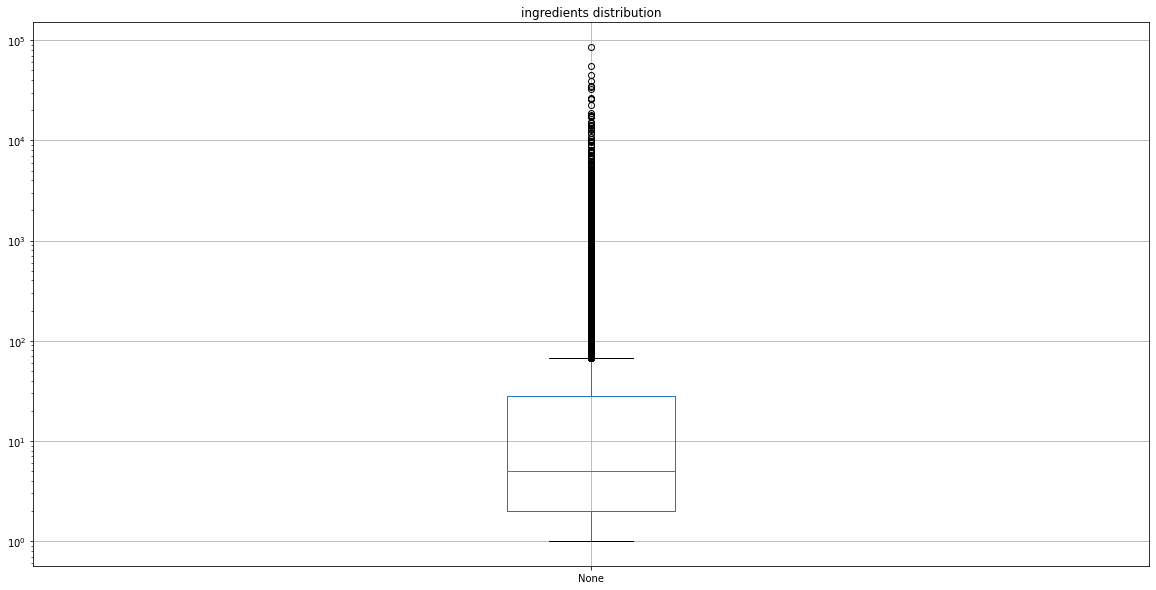

In [ ]:
figure(figsize=(20, 10))
pd.Series(ingrs_dict.values()).plot(
    kind='box',
    title='ingredients distribution',
    grid=True,
    logy=True
)

In [ ]:
get_len = lambda s: len(str(s).split(' '))
title_len = cleaned_recipes_df['name'].apply(get_len)

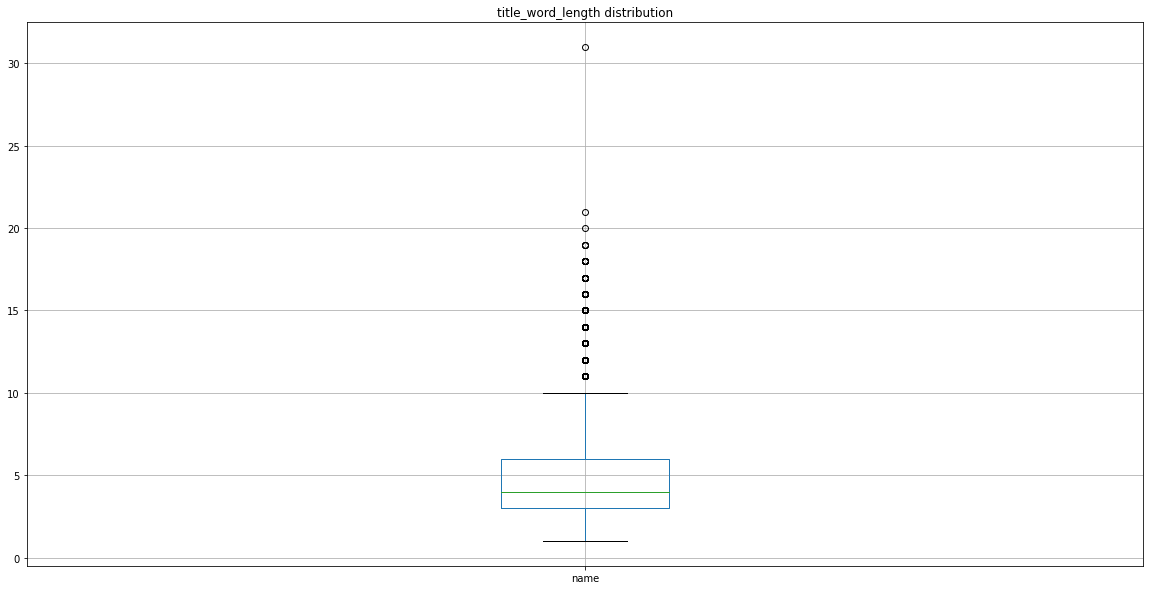

In [ ]:
figure(figsize=(20, 10))
title_len.plot(
    kind='box',
    title='title_word_length distribution',
    grid=True
)

In [ ]:
title_len.describe()

count    231636.000000
mean          4.687186
std           2.160446
min           1.000000
25%           3.000000
50%           4.000000
75%           6.000000
max          31.000000
Name: name, dtype: float64

In [ ]:
title_dict = defaultdict(lambda : 0)

In [ ]:
print(cleaned_recipes_df.shape)
cleaned_recipes_df = cleaned_recipes_df.dropna(subset=['name'])
print(cleaned_recipes_df.shape)

(231636, 18)
(231635, 18)


In [ ]:
def clean_titles(s):
  return ' '.join(s.split())

def get_title_word_count(s):
  words = s.split()
  for w in words:
    title_dict[w] += 1
  

In [ ]:
cleaned_recipes_df['name'] = cleaned_recipes_df['name'].apply(clean_titles)

In [ ]:
cleaned_recipes_df['name'].apply(get_title_word_count)
title_dict

defaultdict(<function __main__.<lambda>>,
            {'arriba': 3,
             'baked': 5275,
             'winter': 276,
             'squash': 1544,
             'mexican': 1732,
             'style': 3364,
             'a': 3517,
             'bit': 27,
             'different': 110,
             'breakfast': 1515,
             'pizza': 2342,
             'all': 368,
             'in': 4338,
             'the': 3982,
             'kitchen': 141,
             'chili': 2809,
             'alouette': 15,
             'potatoes': 4187,
             'amish': 180,
             'tomato': 4111,
             'ketchup': 103,
             'for': 3829,
             'canning': 84,
             'apple': 4631,
             'day': 366,
             'milk': 666,
             'shake': 470,
             'aww': 2,
             'marinated': 896,
             'olives': 414,
             'backyard': 10,
             'barbecued': 467,
             'ribs': 762,
             'bananas': 291,
             '4

In [ ]:
one_letter_words = []
for k in title_dict.keys():
  if len(k) == 1 and k != 'a' and k != 's':
    one_letter_words += [(k, title_dict[k])]

In [ ]:
def get_titles_with_word(s, word, lst):
  words = s.split()
  if word in words:
    lst.append(s)

In [ ]:
one_letter_words

[('4', 331),
 ('i', 353),
 ('t', 331),
 ('1', 471),
 ('5', 405),
 ('m', 236),
 ('n', 1041),
 ('w', 960),
 ('d', 189),
 ('v', 93),
 ('8', 85),
 ('u', 29),
 ('l', 155),
 ('o', 258),
 ('k', 110),
 ('p', 104),
 ('y', 77),
 ('2', 723),
 ('c', 105),
 ('0', 45),
 ('3', 484),
 ('x', 41),
 ('6', 109),
 ('e', 231),
 ('b', 250),
 ('h', 27),
 ('7', 169),
 ('9', 45),
 ('r', 44),
 ('j', 82),
 ('z', 72),
 ('f', 58),
 ('g', 87),
 ('q', 48)]

In [ ]:
res = []
for pair in one_letter_words:
  lst = []
  cleaned_recipes_df['name'].apply(get_titles_with_word, word=pair[0], lst=lst)
  res += lst

In [ ]:
np.savetxt('clean_titles.csv', res, delimiter=',', fmt ='% s')

In [ ]:
import re 

def clean_ingrs(k):
  k = '_'.join(re.split('-| |_', k))
  return k

def clean_tags(k):
  k = '_'.join(re.split('-| |_', k))
  return k


def remove_plurals(ingrs_dict, mapping_dict):
  for k, v in ingrs_dict.items():
    found = False
    if k[-2:] == 'es':
      if k[:-2] in ingrs_dict.keys():
        mapping_dict[k] = k[:-2]
        ingrs_dict[k[:-2]] += ingrs_dict[k]
        found = True
    if k[-1:] == 's' and not found:
      if k[:-1] in ingrs_dict.keys():
        mapping_dict[k] = k[:-1]
        ingrs_dict[k[:-1]] += ingrs_dict[k]

  for ingr, _ in mapping_dict.items():
    print('deleting ' + ingr)
    del ingrs_dict[ingr]

In [ ]:
cleaned_ingrs_dict = {clean_ingrs(k): v for (k, v) in ingrs_dict.items()}
cleaned_tags_dict = {clean_tags(k): v for (k, v) in tags_dict.items()}

In [ ]:
mapping_ingrs_dict = dict()
mapping_tags_dict = dict()

In [ ]:
remove_plurals(cleaned_ingrs_dict, mapping_ingrs_dict)

In [ ]:
remove_plurals(cleaned_tags_dict, mapping_tags_dict)

In [ ]:
def map_tags(lst):
  if type(lst) == 'str':
    lst = ast.literal_eval(lst)
  return [clean_tags(mapping_tags_dict[val]) if val in mapping_tags_dict else clean_tags(val) for val in lst]

def map_ingrs(lst):
  if type(lst) == 'str':
    lst = ast.literal_eval(lst)
  return [clean_ingrs(mapping_ingrs_dict[val]) if val in mapping_ingrs_dict else clean_ingrs(val) for val in lst]

In [ ]:
cleaned_recipes_df['tags'] = cleaned_recipes_df['tags'].apply(map_tags)

In [ ]:
cleaned_recipes_df['ingredients'] = cleaned_recipes_df['ingredients'].apply(map_ingrs)

In [ ]:
cleaned_recipes_df.sample(5)

In [ ]:
cleaned_recipes_df.to_csv('./Food_Com_Dataset/cleaned_recipes.csv')

In [ ]:
pd.DataFrame.from_dict(cleaned_tags_dict, orient='index').to_csv('./Food_Com_Dataset/cleaned_tags.csv')

In [ ]:
pd.DataFrame.from_dict(cleaned_ingrs_dict, orient='index').to_csv('./Food_Com_Dataset/cleaned_ingrs.csv')

In [ ]:
pd.DataFrame.from_dict(title_dict, orient='index').to_csv('./Food_Com_Dataset/titles.csv')

# Data Enrichment from Food.com

In [ ]:
augmented_recipes_df = pd.read_csv('./Food_Com_Dataset/augmented_recipes.csv')

In [ ]:
augmented_recipes_df.sample(5)

In [ ]:
model_data_df = augmented_recipes_df[['id']].merge(cleaned_recipes_df, how='inner', on='id')[['id', 'name', 'tags', 'ingredients']]

In [ ]:
model_data_df.sample(5)

,id,name,tags,ingredients
122662,156844,macadamia nut pina colada bars,"[dessert, 4_hours_or_less, nuts, south_west_pa...","[all_purpose_flour, butter, powdered_sugar, cr..."
208348,316265,tre s dirty three martini,"[for_1_or_2, 3_steps_or_less, easy, beverage, ...","[gin, extra_dry_vermouth, olive_juice, green_o..."
7015,151385,apple poppy seed muffins,"[north_american, brunch, bread, muffins, low_s...","[all_purpose_flour, whole_wheat_flour, brown_s..."
217732,396364,whiskey marinated tenderloins,"[meat, steak, main_dish, high_protein, dinner_...","[bourbon, dark_brown_sugar, worcestershire_sau..."
131441,339051,mistletoe punch,"[beverage, low_saturated_fat, 4_hours_or_less,...","[cranberry_juice_cocktail, orange_juice, water..."


In [ ]:
augmented_recipes_df.columns

Index(['Unnamed: 0', 'name', 'minutes', 'contributor_id', 'submitted', 'tags',
       'n_steps', 'steps_p', 'description', 'ingredients_p', 'n_ingredients',
       'cal', 'totalFat', 'sugar', 'sodium', 'protein', 'satFat', 'carbs',
       'image', 'ingredients', 'steps', 'yields', 'id', 'servings'],
      dtype='object')

In [ ]:
COLUMNS_TO_DROP = ['Unnamed: 0', 'steps_p', 'ingredients_p', 'yields']
database_df = augmented_recipes_df.drop(COLUMNS_TO_DROP, axis=1)

In [ ]:
model_data_df.to_csv('./Food_Com_Dataset/model_data.csv')
database_df.to_csv('./Food_Com_Dataset/database.csv')

In [ ]:
model_data_df = pd.read_csv('./Food_Com_Dataset/model_data.csv', index_col=0)
database_df = pd.read_csv('./Food_Com_Dataset/database.csv', index_col=0)

In [ ]:
s = model_data_df.sample(1, random_state=42)

In [ ]:
s.tags.tolist()

["['north_american', '60_minutes_or_less', 'meat', 'low_saturated_fat', 'rice', 'main_dish', 'micro_melanesia', 'hawaiian', 'chicken', 'low_cholesterol', 'south_west_pacific', 'polynesian', 'white_rice', 'cheap', 'one_dish_meal', 'poultry', 'american']"]

In [ ]:
s.ingredients.tolist()

["['boneless_skinless_chicken_breasts', 'kosher_salt', 'half_and_half', 'flour', 'paprika', 'black_pepper', 'sesame_seeds', 'parsley', 'canola_oil', 'cooked_white_rice', 'butter', 'chicken_bouillon_cubes', 'cayenne_pepper', 'water']"]